
# Grid embeddings
``neuralop.layers.embeddings.GridEmbedding2D`` and ``neuralop.layers.embeddings.GridEmbeddingND`` provide interfaces for appending 
grid positional embeddings to your data to improve model generalization. In this example we showcase their use and visualize their outputs.


In [1]:
import random
import matplotlib.pyplot as plt
import torch

device = 'cpu'

## Basic logic
As we show in `small_darcy_vis`, we apply a 2d grid positional encoding to our data before passing it into the FNO. 
This embedding has been shown to improve model performance in a variety of applications. 
Let's walk through its use. We start with a function that gives the coordinates of the bottom-left corners of each pixel in a grid:
%%



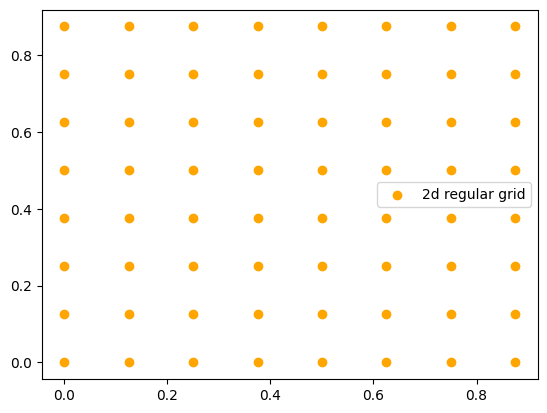

In [2]:
from neuralop.layers.embeddings import regular_grid_2d
grid_2d = torch.stack(regular_grid_2d(spatial_dims=(8,8))).permute(1,2,0).view(-1,2) #reshape into (64, 2)

plt.scatter(grid_2d[:, 0], grid_2d[:, 1], color='orange', label="2d regular grid")
plt.legend()

## Applying embedding to data
In practice, we concatenate these two channels, representing the x- and y-coordinates of each pixel in an example, 
after the channels which encode physical variables in our PDE problems:



Loading test db for resolution 16 with 16 samples 
Loading test db for resolution 32 with 16 samples 
One batch of x is of shape: torch.Size([2, 1, 16, 16])
After embedding, x is of shape: torch.Size([2, 3, 16, 16])


c:\Users\alfre\OneDrive\Documentos\Universidad\9NO SEMESTRE\EDPN\Proyecto_FNO\fno_venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\alfre\AppData\Local\Temp\ipykernel_14340\674241171.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


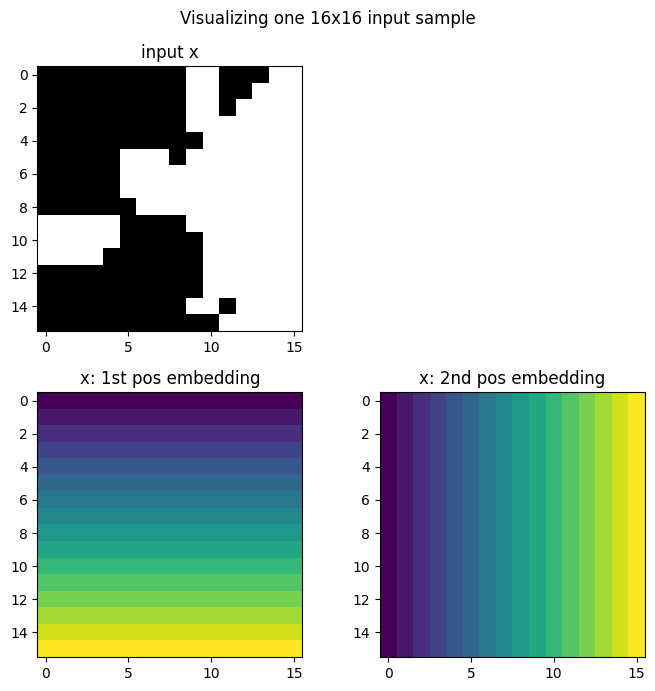

In [3]:
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D

_, test_loaders, _ = load_darcy_flow_small(
        n_train=10, batch_size=1, 
        test_resolutions=[16, 32], n_tests=[16, 16],
        test_batch_sizes=[2, 2], 
        encode_output=False
)

loader_16 = test_loaders[16]
example = next(iter(loader_16))
x = example['x']
print(f"One batch of x is of shape: {x.shape}")

# Note: our Darcy dataset is generated on the unit square, but our grid 
# embedding's boundaries are configurable.
grid_embedding = GridEmbedding2D(in_channels=1, grid_boundaries=[[0,1], [0,1]])
x = grid_embedding(x)
print(f"After embedding, x is of shape: {x.shape}")

# grab the first element of the batch
x = x[0]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one 16x16 input sample', y=0.98)
plt.tight_layout()
fig.show()

Our embeddings are also designed with discretization-invariance in mind.
Without any changes, we can apply the same embedding to higher-resolution data:



One batch of x is of shape: torch.Size([2, 1, 32, 32])
After embedding, x is of shape: torch.Size([2, 3, 32, 32])


C:\Users\alfre\AppData\Local\Temp\ipykernel_14340\3559633879.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


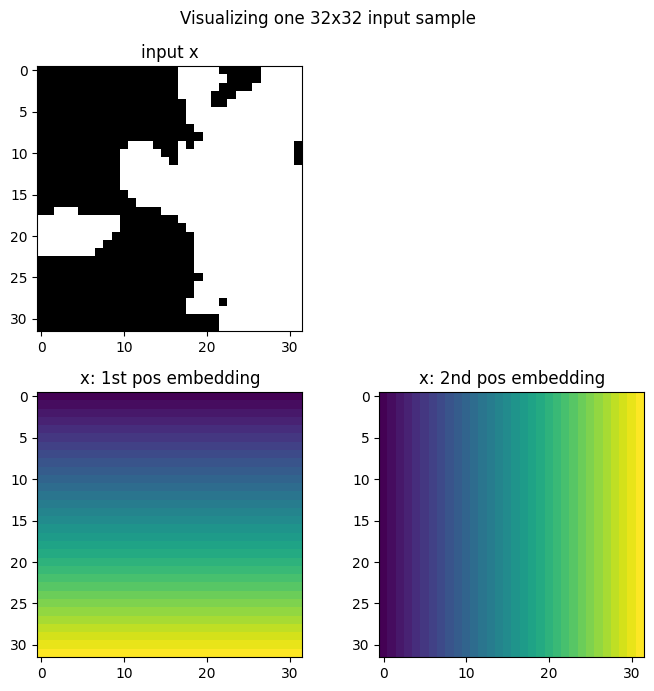

In [4]:
loader_32 = test_loaders[32]
example = next(iter(loader_32))
x = example['x']
print(f"One batch of x is of shape: {x.shape}")

x = grid_embedding(x)
print(f"After embedding, x is of shape: {x.shape}")

# grab the first element of the batch
x = x[0]
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one 32x32 input sample', y=0.98)
plt.tight_layout()
fig.show()

%%
Let's also embed a 3d tensor.
Assuming we have one channel of data discretized on a 5x5x5 cube:



Text(0.5, 0, 'Z')

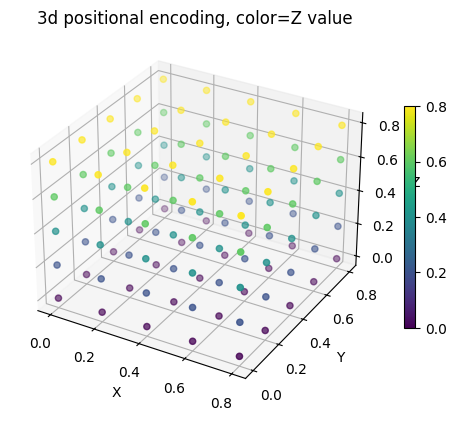

In [6]:
from neuralop.layers.embeddings import GridEmbeddingND
cube_len = 5
x = torch.randn(1, 1, cube_len, cube_len, cube_len)
embedding_3d = GridEmbeddingND(in_channels=1, dim=3, grid_boundaries=[[0,1]]*3)

x = embedding_3d(x)
# grab only the appended positional embedding channels
x = x[0,1:,...].permute(1,2,3,0).view(-1, 3)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plot = ax.scatter(x[:,0], x[:, 1], x[:, 2], c=x[:, 2])
fig.colorbar(plot, ax=ax, shrink=0.6)
ax.set_title("3d positional encoding, color=Z value")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")